In [1]:
# This is to test the inheritance of functions in python. 
# If a function F of same name exists in class B and class A where B inherits from A, 
# then for instance of B function from F from B will be used. 

# class A:
    
#     def __init__(self,a):
        
#         self.a = a
#         return None 
    
#     def check(self):
#         print("Helloe")
#         return None 
    
#     def newPrint(self):
        
#         print('This is from class A:  ',self.a)
#         return None
    
    
# class B(A):
    
#     def __init__(self,b):
        
#         self.b = b
#         return None
    
#     def newPrint(self):
#         print('This is from class B', self.b)
#         return None 

In [2]:
from essentials import *
%matplotlib inline 

def get_nestedness(BiMat):
    
    '''
    takes the biAdjacency matrix of the bipartite graph and
    gives the nestedness calculated from the R script 
    '''
    
    np.savetxt('graph_matrices/test.csv',BiMat,delimiter=',')
    
    import subprocess

    cmd = r'''cd /Users/chakreshsingh/Documents/bipartite_growth_models/ | Rscript mat_temp.R'''

    x = float(subprocess.check_output(cmd, shell=True))
    
    return x

## To Consider 

* make sure that the init_edges is a number 
* adding of edges should be different node types. Here we have no way to distinguish that in the edges description. therefore we start the bottom edges from the T parameter since that is the maximum number of top nodes there ever will be in the model

In [5]:
G1 = ramasco_model(1,3,1000,n_top=2,n_btm=3,init_edges=2,init=False)

In [6]:
G = G1.simulate()

In [7]:
topNodes = [n for n,j in G.nodes(data=True) if j['bipartite']==0]
btmNodes = [n for n,j in G.nodes(data=True) if j['bipartite']==1]

In [8]:
btm_projection = bipartite.projected_graph(G,btmNodes)

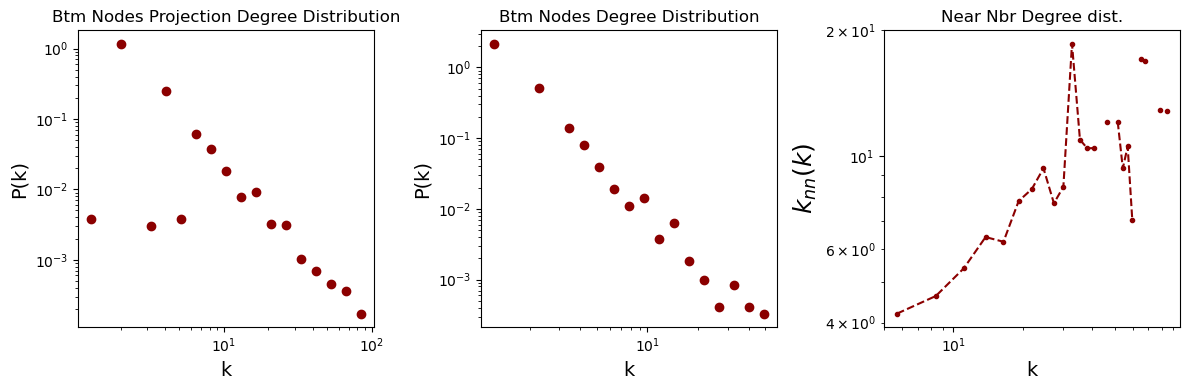

In [9]:
fig,ax = plt.subplots(figsize=(12,4),ncols=3,sharex=False,sharey=False)

G1.plot_dd(btm_projection,False,'Btm Nodes Projection',axes=ax[0])
G1.plot_dd(G,1,'Btm Nodes',axes=ax[1])
G1.plot_degcorr(btm_projection,'',axes=ax[2])
fig.tight_layout()

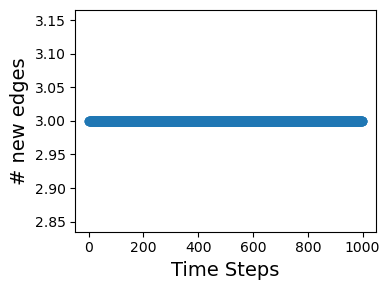

In [10]:
plt.figure(figsize=(4,3))
plt.plot(range(1,G1.totalTime),G1.n_edges[1:]-G1.n_edges[:-1],'-o')
plt.xlabel('Time Steps',fontdict={'size':14})
plt.ylabel('# new edges',fontdict={'size':14})
plt.tight_layout()

In [11]:
# help(np.random.choice)

In [12]:
Gu = user_object_model(5,3,2,1000,2,2)

In [13]:
G2 = Gu.simulate()

In [14]:
topNodes = [n for n,j in G2.nodes(data=True) if j['bipartite']==0]
btmNodes = [n for n,j in G2.nodes(data=True) if j['bipartite']==1]

In [15]:
btm_projection = bipartite.projected_graph(G2,btmNodes)

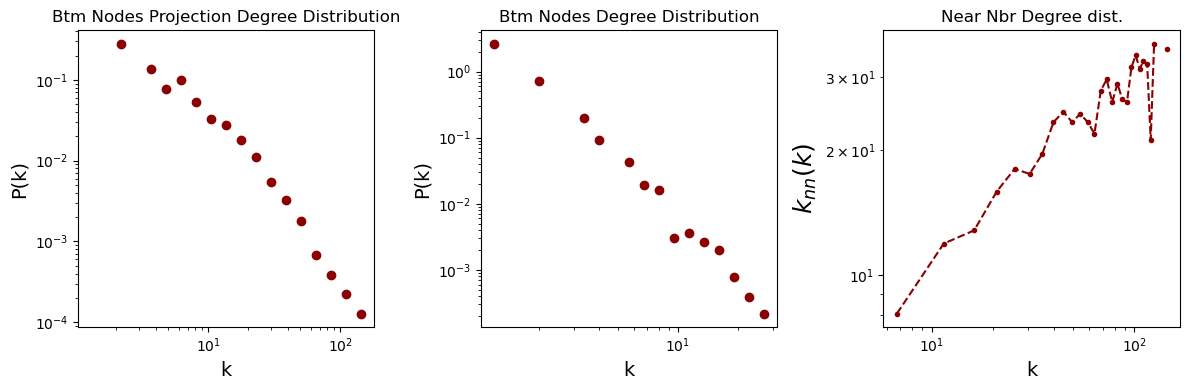

In [16]:
fig,ax = plt.subplots(figsize=(12,4),ncols=3,sharex=False,sharey=False)

Gu.plot_dd(btm_projection,False,'Btm Nodes Projection',axes=ax[0])
Gu.plot_dd(G2,1,'Btm Nodes',axes=ax[1])
Gu.plot_degcorr(btm_projection,'',axes=ax[2])
fig.tight_layout()

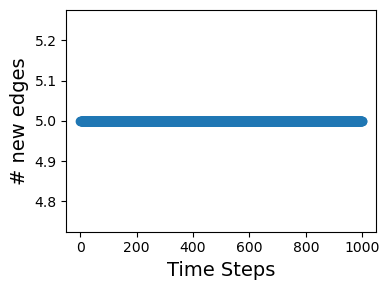

In [17]:
plt.figure(figsize=(4,3))
plt.plot(range(1,Gu.totalTime),Gu.n_edges[1:]-Gu.n_edges[:-1],'-o')
plt.xlabel('Time Steps',fontdict={'size':14})
plt.ylabel('# new edges',fontdict={'size':14})
plt.tight_layout()

In [18]:
## creating a function running n simulations and reporting average degree distribution 

In [19]:
import multiprocessing
multiprocessing.cpu_count()

10

In [20]:
import multiprocessing as mp
import os

def main():
    # Get the number of CPU cores on the system
    num_procs = mp.cpu_count()
    print(f"This system has {num_procs} CPU cores.")

    # Create a pool of worker processes
    ctx = mp.get_context('spawn')
    with ctx.Pool(processes=num_procs) as pool:

        # Run the worker function in parallel on the pool
        results = pool.map(multi_sim, range(100))

    print("All work completed.")
    return results
    
if __name__ == '__main__':
    try:
        mp.set_start_method('spawn')
    except RuntimeError:
        pass
    
    Results = main()


This system has 10 CPU cores.
All work completed.


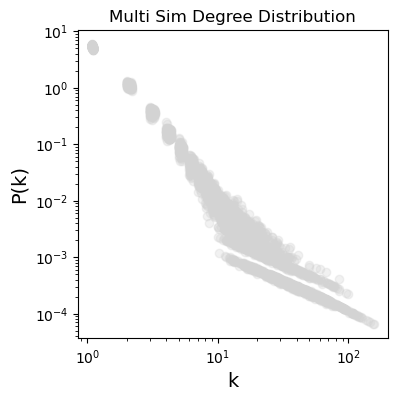

In [21]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

for r in Results:
    
    plot_dd(r,'Multi Sim',ax)
    

In [22]:
from sympy import *

In [23]:
# k = range(1,100)
# r,s,k0=1,2,3
r = Symbol('r')
s = Symbol('s')
k0 = Symbol('k0')
K = Symbol('K')
k=Symbol('k')

In [24]:
integrate((r/s)*((k0)**(r/s))*(1/(k+k0)**(1+(r/s))),(k,0,k))

Piecewise((-k0**(r/s)/(k + k0)**(r/s) + 1, Ne(r/s, 0)), (-k0**(r/s)*r*log(k0)/s + k0**(r/s)*r*log(k + k0)/s, True))

In [26]:
gamma_e = np.random.random_integers(1,50,2)
gamma_i = np.random.random_integers(1,100,2)

w,m,n = 5,3,2

nt = 514

Z = []

for i,j in tqdm(zip(gamma_e,gamma_i)):
    print(i,j)
    model = user_object_model(w,m,n,nt,i,j)
    G = model.simulate()
    B = [n for n,j in G.nodes(data=True) if j['bipartite']==1]
    T = [n for n,j in G.nodes(data=True) if j['bipartite']==0]
    
    BiMat = bipartite.biadjacency_matrix(G,row_order=B,column_order=T).toarray()
    
    Z.append(get_nestedness(BiMat))

/var/folders/nh/5jq2mlf15kvc6qs_xh074tn80000gn/T/ipykernel_35754/465531408.py:1: DeprecationWarning: This function is deprecated. Please call randint(1, 50 + 1) instead
  gamma_e = np.random.random_integers(1,50,2)
/var/folders/nh/5jq2mlf15kvc6qs_xh074tn80000gn/T/ipykernel_35754/465531408.py:2: DeprecationWarning: This function is deprecated. Please call randint(1, 100 + 1) instead
  gamma_i = np.random.random_integers(1,100,2)
0it [00:00, ?it/s]

31 62


1it [00:30, 30.24s/it]

18 11


2it [01:00, 30.13s/it]


In [3]:
with open('simulation_nestedness_v2.json','r') as f:
    
    N = json.load(f)

In [12]:
x = np.array(N['gamma_e'])
y = np.array(N['gamma_i'])
z = np.array(N['Z'])

In [13]:
x,y = np.meshgrid(x,y)
z = z.reshape(30,30)

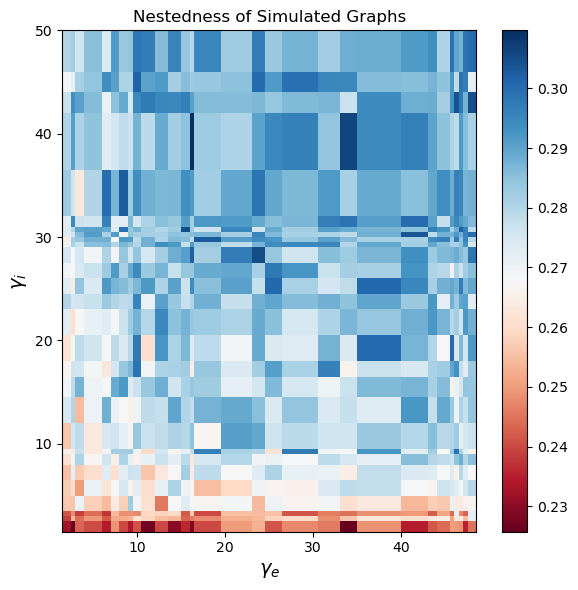

In [17]:
import matplotlib.pyplot as plt
import numpy as np
 
# x, y = np.meshgrid(np.linspace(-3, 3, 2), np.linspace(-3, 3, 2))
# z = (1 - x*y) - np.sin(x**2 + y**2 )
# z = z[:-1, :-1]
 
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title('Nestedness of Simulated Graphs')
 
plt.pcolormesh(x, y, z, cmap='RdBu', vmin = np.min(z), 
                                     vmax = np.max(z))
plt.colorbar()
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$\gamma_{e}$',fontsize=14)
plt.ylabel(r'$\gamma_{i}$',fontsize=14)
plt.tight_layout()
# plt.savefig('plots/simulated_nestedness.png',dpi=600)
plt.show()

In [1]:
### Fitting the distributions ########

In [31]:
def user_obj_cdf(k,k0,r,s):
    
    return 1 - ((k+k0)/k0)**(-r/s)

def ramasco_pdf(k,y,n):
    
    return (k+(y-0.5)*(n-1))**(-y)